In [12]:
import pymc as pm
import netCDF4 as nc
import numpy as np
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt


events = ["GW150914","GW170104","GW170823","GW190519_153544",
          "GW190521","GW190521_074359","GW190706_222641",
          "GW190828_063405","GW200224_222234","GW200311_115853"]

ds = {}
points = {}

for event in events:
    fn = f"./ChargedResults/{event}/{event}-charged-posteriors.nc"
    a = nc.Dataset(fn)
    ds[event] = a
    points[event] = np.array([np.array(x) for x in zip(a['posterior']['chi'][:].flatten(),a['posterior']['Q_charge'][:].flatten())])

events_that_look_alright = ['GW150914','GW190519_153544',
                            'GW190521','GW190521_074359',
                            'GW190706_222641','GW200224_222234']

n_events = len(events_that_look_alright)

points_good = {k:v for k,v in points.items() if k in events_that_look_alright}

In [2]:
from sklearn.mixture import GaussianMixture

n_gauss = 20
GMMs = {}

for eventname, samples in points_good.items():
    GMMs[eventname] = GaussianMixture(n_components=n_gauss).fit(samples)

In [3]:
eventnames = list(GMMs.keys())
GMM_means = np.array([GMMs[eventname].means_ for eventname in eventnames])
GMM_weights = np.array([GMMs[eventname].weights_ for eventname in eventnames])
GMM_covariances = np.array([GMMs[eventname].covariances_ for eventname in eventnames])

In [5]:
GMM_means.shape

(6, 20, 2)

In [7]:
import pystan
analysis_data = {
             'Nobs': n_events,
             'NC': n_gauss,
             'weights': GMM_weights,
             'covs': GMM_covariances,
             'means': GMM_means
            }

compiled = pystan.StanModel(file='hierGRtest2D.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed2a4114b2a26122cdb396b4f679006e NOW.
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/x2/flf3cm9506vdxng0c9g04p440000gn/T/tmp_s0e447r/stanfit4anon_model_ed2a4114b2a26122cdb396b4f679006e_7014652151303798375.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
fit = compiled.sampling(data=analysis_data, iter=8000, chains=4)

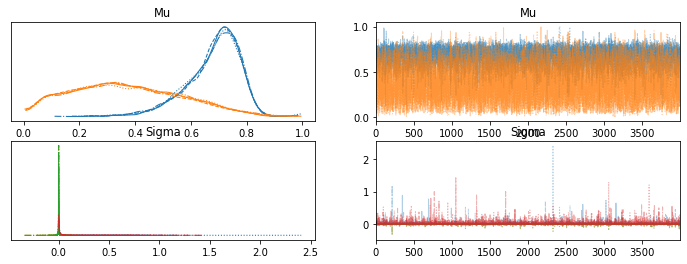

In [20]:
az.plot_trace(fit,
              var_names=['Mu', 'Sigma'],
              compact=True);

In [46]:
new_pystan_fit = az.convert_to_inference_data(fit)

In [47]:
new_pystan_fit.to_netcdf('new_pystan_fit.nc')

'new_pystan_fit.nc'

In [35]:
xpop_data = az.convert_to_inference_data(fit).posterior['xpop'].values

In [36]:
xpop_data2 = xpop_data.reshape((xpop_data.shape[0]*xpop_data.shape[1],xpop_data.shape[2]))

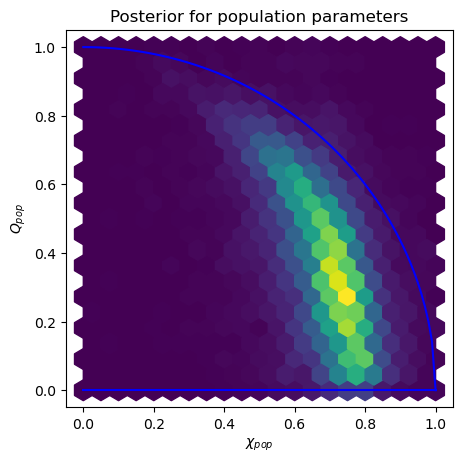

In [44]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)

ax.set_xlabel(r"$\chi_{pop}$")
ax.set_ylabel(r"$Q_{pop}$")
ax.hexbin(xpop_data2[:,0],xpop_data2[:,1],gridsize=20, extent=(0,1,0,1))
ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
ax.set_title("Posterior for population parameters")

plt.show()